<a href="https://colab.research.google.com/github/rithik2812/speech/blob/main/speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa soundfile numpy matplotlib tensorflow keras scikit-learn gradio resampy

import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Reshape, Input, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import soundfile as sf
import zipfile
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


ZIP_PATH = "/content/drive/MyDrive/RAVDESS/archive (1).zip"
EXTRACT_PATH = "/content/RAVDESS"

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

print("Dataset extracted successfully!")

Mounted at /content/drive
Dataset extracted successfully!


In [ ]:
def extract_features(file_path, max_pad_len=100):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)

        if mfccs.shape[1] > max_pad_len:
            mfccs = mfccs[:, :max_pad_len]
        else:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [ ]:
DATASET_PATH = "/content/RAVDESS"
X = []
y = []

labels_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

In [ ]:
for root, _, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion_label = labels_map.get(file.split("-")[2], "unknown")
            features = extract_features(file_path)
            if features is not None:
                X.append(features.tolist())
                y.append(emotion_label)

In [ ]:
X = np.array(X, dtype=np.float32).reshape(-1, 100, 40, 1)
y = np.array(y)

encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:

model = Sequential([
    Input(shape=(100, 40, 1)),
    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Reshape((25, -1)),

    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(labels_map), activation='softmax')
])

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test)
)
model.save("emotion_recognition_model.h5")

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.1186 - loss: 2.0984 - val_accuracy: 0.1615 - val_loss: 2.0621
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.1340 - loss: 2.0844 - val_accuracy: 0.1667 - val_loss: 2.0459
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.1438 - loss: 2.0661 - val_accuracy: 0.1997 - val_loss: 2.0542
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.1502 - loss: 2.0600 - val_accuracy: 0.1632 - val_loss: 2.0169
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.1644 - loss: 2.0295 - val_accuracy: 0.2257 - val_loss: 1.9890
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.1971 - loss: 2.0051 - val_accuracy: 0.1858 - val_loss: 1.9779
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.1942 - loss: 1.9968 - val_accuracy: 0.2465 - val_loss: 1.9334
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.2085 - loss: 1.9581 - val_accuracy: 0.2812 - val_loss:

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.75      0.55      0.64        76
        calm       0.58      0.92      0.71        77
     disgust       0.57      0.75      0.65        77
     fearful       0.69      0.70      0.70        77
       happy       0.74      0.51      0.60        77
     neutral       0.65      0.34      0.45        38
         sad       0.47      0.48      0.47        77
   surprised       0.85      0.73      0.78        77

    accuracy                           0.64       576
   macro avg       0.66      0.62      0.63       576
weighted avg       0.66      0.64      0.64       576

Accuracy: 0.64


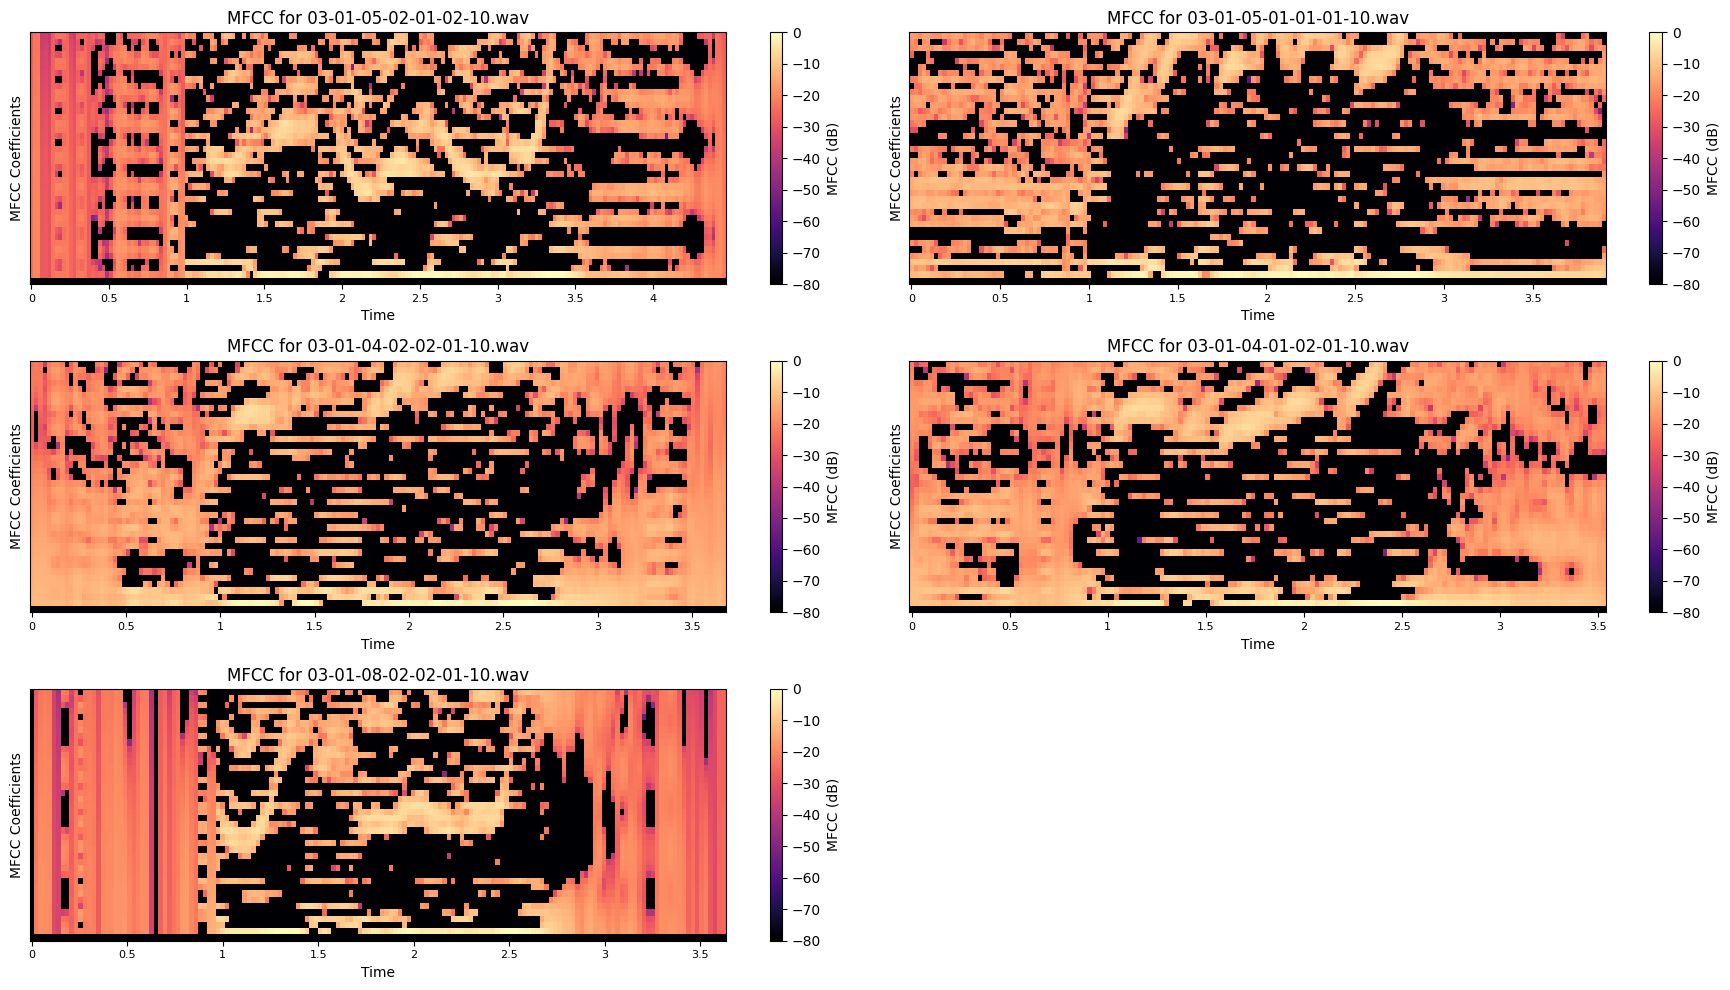

In [ ]:
audio_files = []
for root, _, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))
    if len(audio_files) >= 5:
        break

plt.figure(figsize=(18, 10))

for i, file in enumerate(audio_files[:5]):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')

    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_db = librosa.power_to_db(mfccs, ref=np.max)

    plt.subplot(3, 2, i+1)
    librosa.display.specshow(mfccs_db, sr=sample_rate, x_axis='time', cmap='magma')
    plt.title(f"MFCC for {os.path.basename(file)}", fontsize=12)
    plt.xlabel("Time", fontsize=10)
    plt.ylabel("MFCC Coefficients", fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

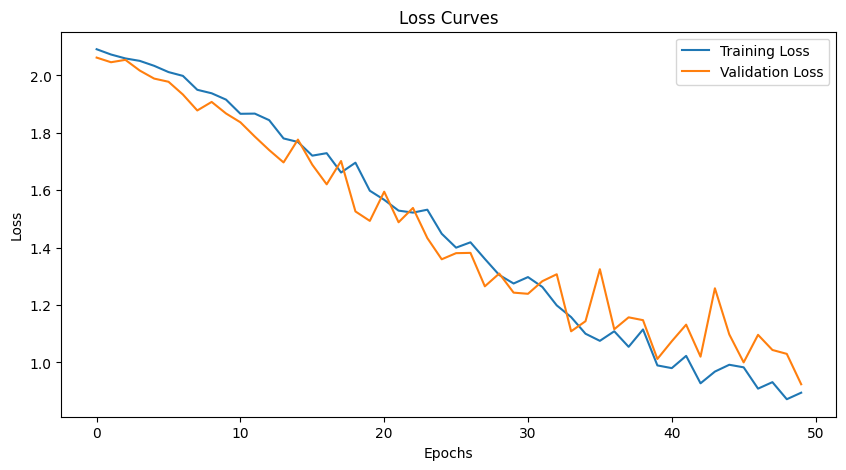

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

In [ ]:

def predict_emotion(audio_file):
    try:
        print(f"Processing file: {audio_file}")
        features = extract_features(audio_file, max_pad_len=100)

        if features is None or features.shape[1] < 100:
            return "Error: Could not process the audio file properly. Ensure it's a valid .wav file."

        features = features.reshape(1, 100, 40, 1)
        prediction = np.argmax(model.predict(features))
        emotion = encoder.inverse_transform([prediction])[0]
        print(f"Predicted emotion: {emotion}")
        return f"Predicted Emotion: {emotion}"
    except Exception as e:
        return f"Error processing audio: {e}"


demo = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Audio(type="filepath"),
    outputs="text",
    title="Speech Emotion Recognition",
    description="Upload an audio file (.wav) to predict the emotion."
)

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://867096b3501437a279.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


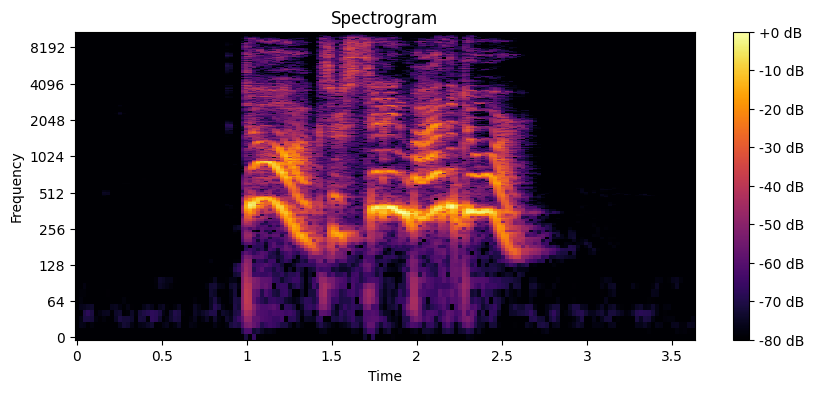

In [ ]:
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

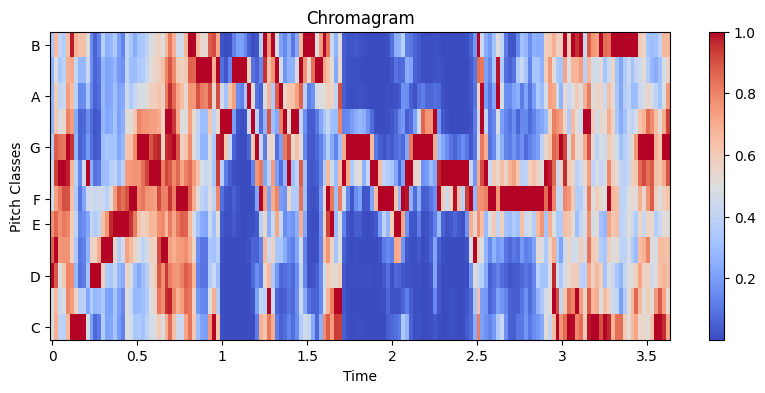

In [ ]:
plt.figure(figsize=(10, 4))
chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title('Chromagram')
plt.xlabel("Time")
plt.ylabel("Pitch Classes")
plt.show()


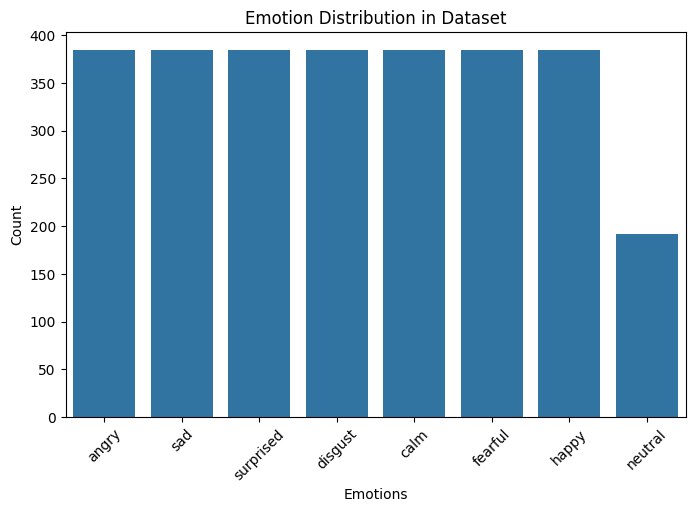

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.countplot(x=[encoder.classes_[label] for label in y])
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Emotion Distribution in Dataset")
plt.xticks(rotation=45)
plt.show()